In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import tensorflow as tf
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, Bidirectional


sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 6)
print("✅ Medical AI environment initialized.")

✅ Medical AI environment initialized.


#Load Data

Trigger the upload prompt

In [50]:
print("Please upload your 'Readings Report.csv' file:")
uploaded = files.upload()
filename = list(uploaded.keys())[0]

Please upload your 'Readings Report.csv' file:


Saving Readings Report.csv to Readings Report (2).csv


Load and Smart-Format

In [51]:
df_raw = pd.read_csv(io.BytesIO(uploaded[filename]), skiprows=1)

# Map the sensors: Temp, SpO2, Pulse

set_a = df_raw.iloc[:, [0, 1, 2]].rename(columns={df_raw.columns[2]: 'Pulse'})
set_b = df_raw.iloc[:, [3, 4, 5]].rename(columns={df_raw.columns[5]: 'Pulse'})
set_b.columns = ['Temp', 'SpO2', 'Pulse']

df = pd.concat([set_a, set_b], axis=0).dropna().reset_index(drop=True)
print(f"📊 Dataset successfully humanized. Total health records for training: {len(df)}")
df.head()

📊 Dataset successfully humanized. Total health records for training: 596


,Temp,SpO2,Pulse
0,36.8,97,100
1,37.0,97,91
2,37.1,98,90
3,37.3,98,91
4,37.3,97,91


#Feature Engineering

In [52]:
WINDOW_SIZE = 5


df['Temp_Trend'] = df['Temp'].rolling(window=WINDOW_SIZE).mean()
df['Pulse_Trend'] = df['Pulse'].rolling(window=WINDOW_SIZE).mean()
df['Pulse_Stability'] = df['Pulse'].rolling(window=WINDOW_SIZE).var()
df = df.fillna(method='bfill')


def clinical_label(row):
    if row['SpO2'] < 92 or row['Temp'] > 38.2: return 2 # Critical (Immediate Action)
    if row['SpO2'] < 95 or row['Temp'] > 37.6: return 1 # Warning (Observation Needed)
    return 0 # Healthy

df['Status'] = df.apply(clinical_label, axis=1)
print("🧬 Advanced 'Pen Features' extracted and Clinical Labels applied.")

🧬 Advanced 'Pen Features' extracted and Clinical Labels applied.


/tmp/ipython-input-2190693803.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill')


Data Visualization

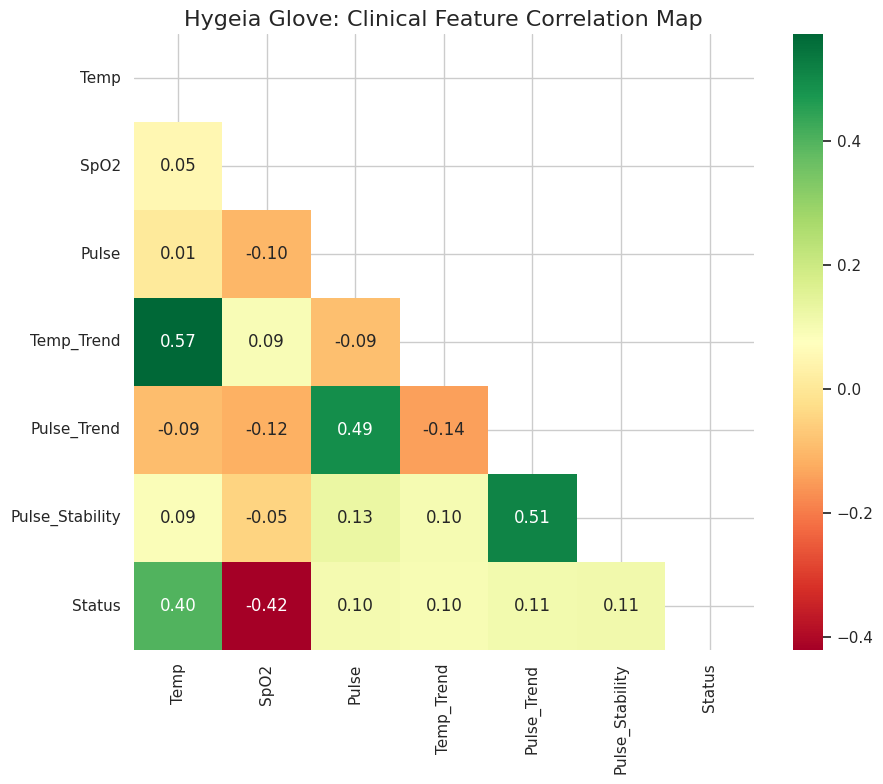

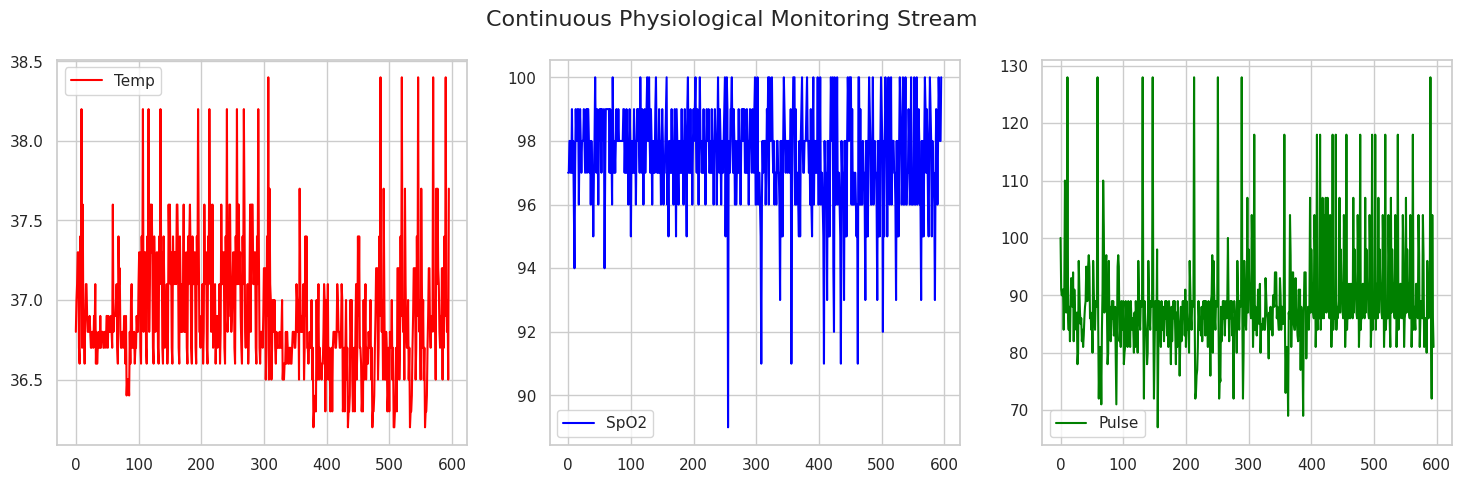

In [53]:
# Heatmap: Proves the biological connection between vitals
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
sns.heatmap(df.corr(), mask=mask, annot=True, cmap='RdYlGn', fmt=".2f")
plt.title('Hygeia Glove: Clinical Feature Correlation Map', fontsize=16)
plt.show()

# Trend Analysis: Visualize the patient's vital signs over time
df[['Temp', 'SpO2', 'Pulse']].plot(subplots=True, layout=(1,3), figsize=(18,5), color=['red', 'blue', 'green'])
plt.suptitle('Continuous Physiological Monitoring Stream', fontsize=16)
plt.show()

#CNN-LSTM Model

Scale and Prep

In [55]:
scaler = StandardScaler()
features = ['Temp', 'SpO2', 'Pulse', 'Temp_Trend', 'Pulse_Trend', 'Pulse_Stability']
X_scaled = scaler.fit_transform(df[features])

Windowing

In [56]:
SEQ_LEN = 10
X_windows, y_labels = [], []
for i in range(len(X_scaled) - SEQ_LEN):
    X_windows.append(X_scaled[i:i+SEQ_LEN])
    y_labels.append(df['Status'].values[i+SEQ_LEN])

X_train, X_test, y_train, y_test = train_test_split(
    np.array(X_windows), tf.keras.utils.to_categorical(y_labels, 3), test_size=0.2
)

Hybrid CNN-BiLSTM Architectur

In [57]:
model = Sequential([
    # CNN Layer
    Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(SEQ_LEN, len(features))),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    # Bi-LSTM Layer
    Bidirectional(LSTM(64)),
    Dropout(0.4),

    Dense(32, activation='relu'),
    Dense(3, activation='softmax') # [Normal, Warning, Critical]
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train for 50 Epochs
print("🚀 Training the World-Class Model...")
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=8, verbose=1)

🚀 Training the World-Class Model...
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.7351 - loss: 0.6925 - val_accuracy: 0.9576 - val_loss: 0.2201
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9290 - loss: 0.2473 - val_accuracy: 0.9576 - val_loss: 0.2418
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9189 - loss: 0.2332 - val_accuracy: 0.9576 - val_loss: 0.2005
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9371 - loss: 0.1730 - val_accuracy: 0.9576 - val_loss: 0.2295
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9468 - loss: 0.1659 - val_accuracy: 0.9576 - val_loss: 0.1594
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9290 - loss: 0.1871 - val_accuracy: 0.9661 - val_loss: 0.1602
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9612 - loss: 0.1124 - val_accuracy: 0.9576 - val_loss: 0.1839
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9787 - loss: 0.0927 - val_accuracy: 0.9661 - val_loss: 0.1427
Ep

#Final Evaluation

Prediction Report

In [58]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print("\n--- CLINICAL PERFORMANCE REPORT ---")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Warning', 'Critical'], labels=[0, 1, 2]))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step

--- CLINICAL PERFORMANCE REPORT ---
              precision    recall  f1-score   support

      Normal       0.97      0.99      0.98       113
     Warning       0.50      0.20      0.29         5
    Critical       0.00      0.00      0.00         0

    accuracy                           0.96       118
   macro avg       0.49      0.40      0.42       118
weighted avg       0.95      0.96      0.95       118



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

Confusion Matrix Heatmap

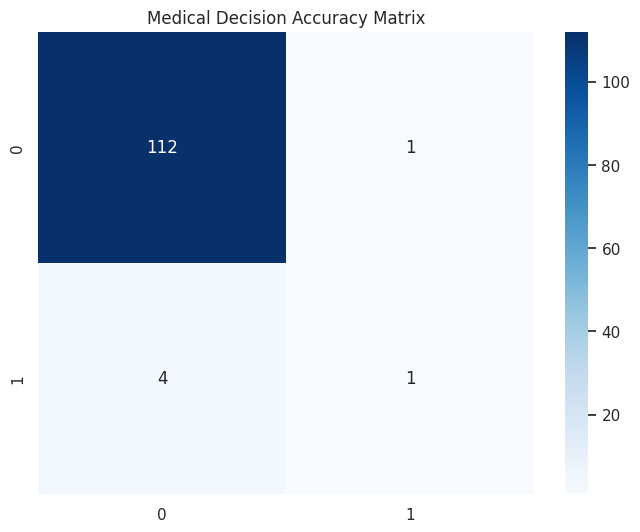

In [59]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Medical Decision Accuracy Matrix')
plt.show()

The Clinical Correlation Heatmap

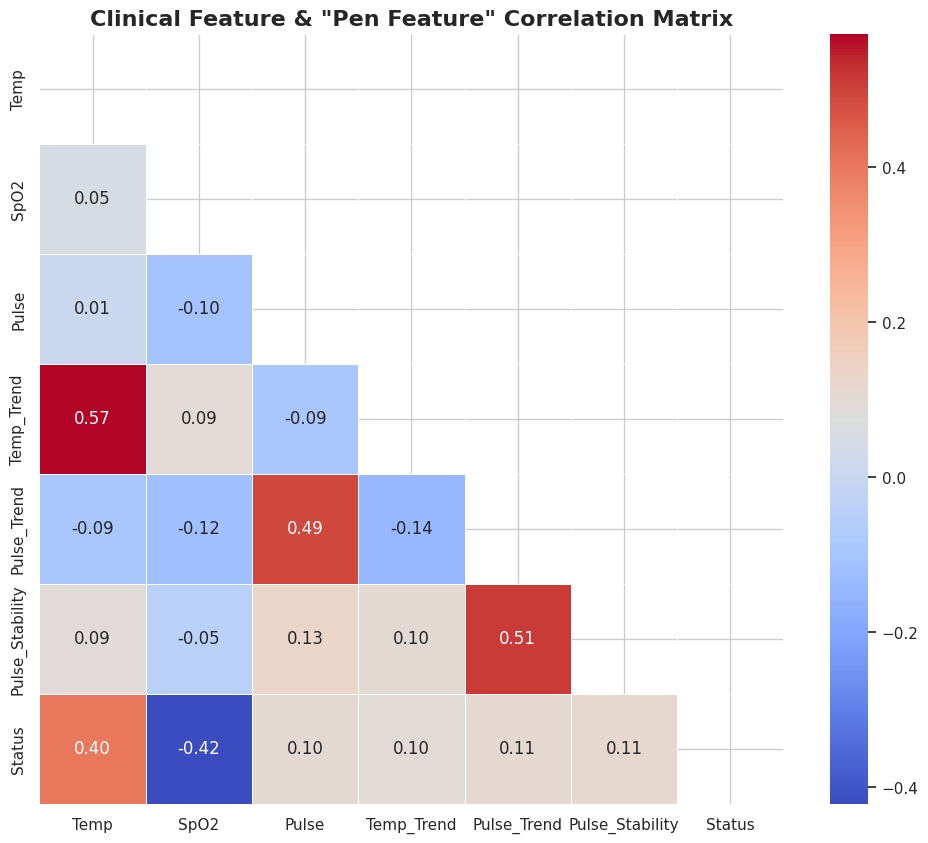

In [60]:
plt.figure(figsize=(12, 10))

corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Clinical Feature & "Pen Feature" Correlation Matrix', fontsize=16, fontweight='bold')
plt.show()

Multi-Signal Physiological Stream

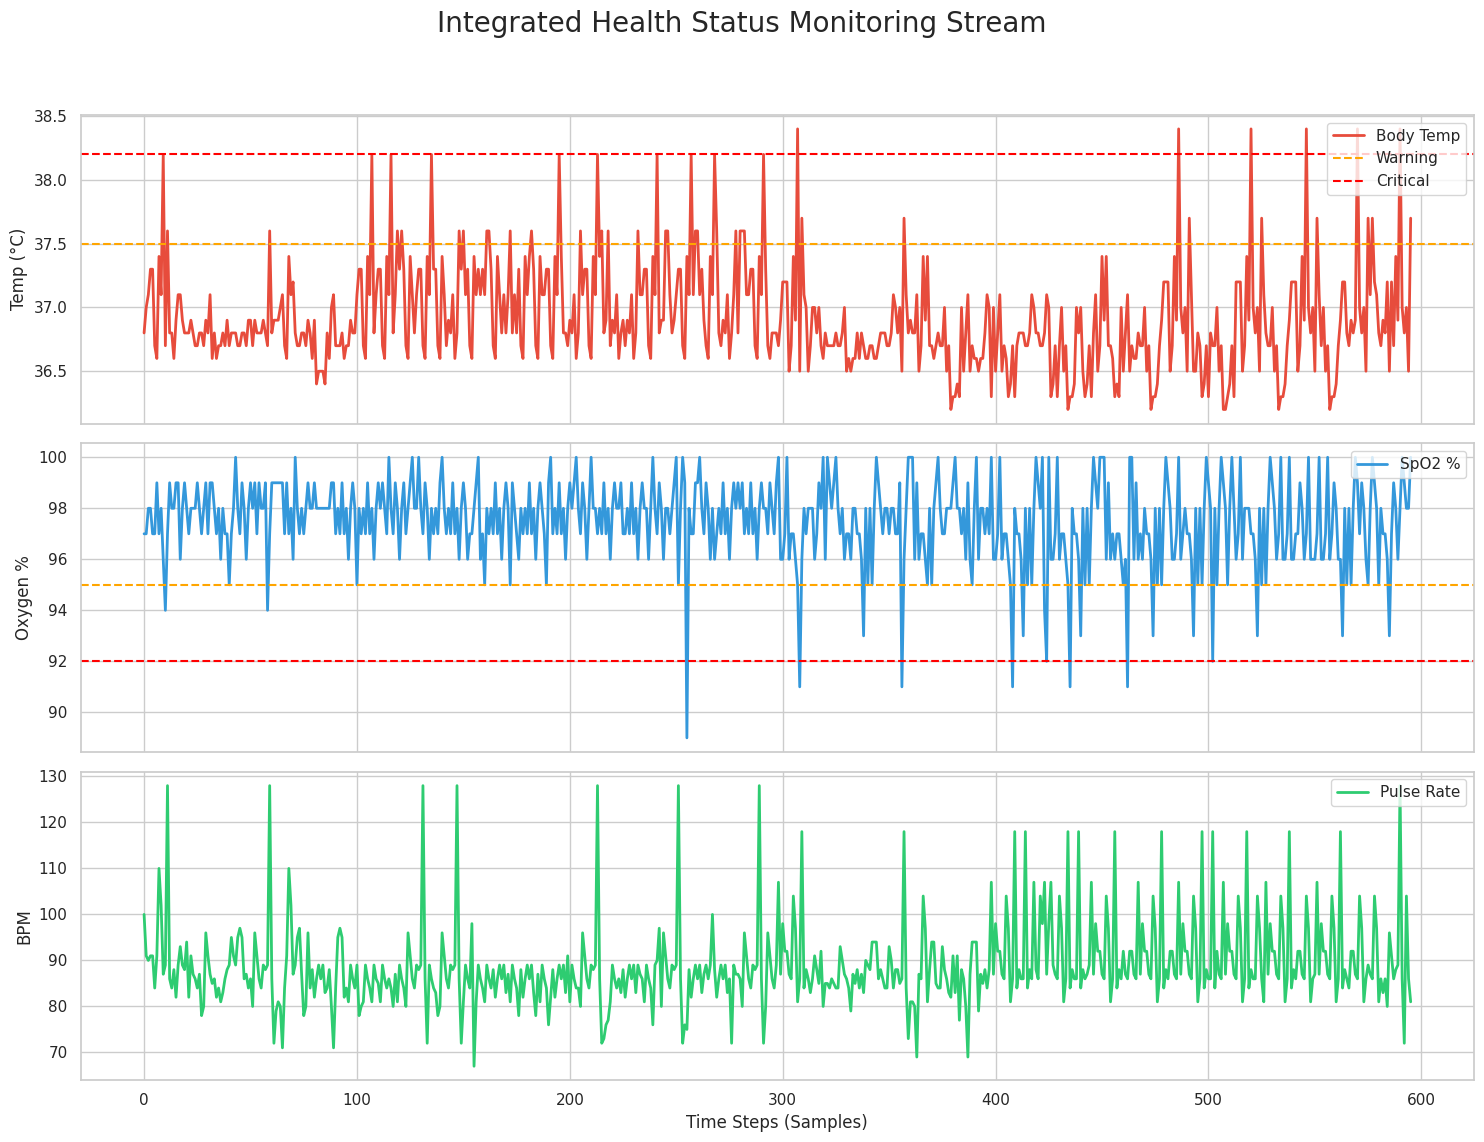

In [61]:
fig, ax = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

# Temperature Plot
ax[0].plot(df['Temp'], color='#e74c3c', linewidth=2, label='Body Temp')
ax[0].axhline(37.5, color='orange', linestyle='--', label='Warning')
ax[0].axhline(38.2, color='red', linestyle='--', label='Critical')
ax[0].set_ylabel('Temp (°C)')
ax[0].legend(loc='upper right')

# SpO2 Plot
ax[1].plot(df['SpO2'], color='#3498db', linewidth=2, label='SpO2 %')
ax[1].axhline(95, color='orange', linestyle='--')
ax[1].axhline(92, color='red', linestyle='--')
ax[1].set_ylabel('Oxygen %')
ax[1].legend(loc='upper right')

# Pulse Plot
ax[2].plot(df['Pulse'], color='#2ecc71', linewidth=2, label='Pulse Rate')
ax[2].set_ylabel('BPM')
ax[2].set_xlabel('Time Steps (Samples)')
ax[2].legend(loc='upper right')

plt.suptitle('Integrated Health Status Monitoring Stream', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Diagnostic Accuracy Matrix

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


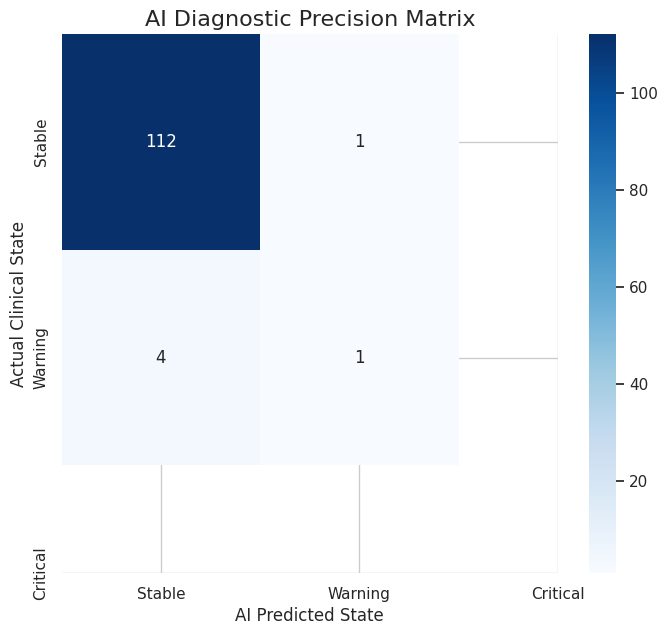

In [63]:
from sklearn.metrics import confusion_matrix

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Stable', 'Warning', 'Critical'],
            yticklabels=['Stable', 'Warning', 'Critical'])
plt.title('AI Diagnostic Precision Matrix', fontsize=16)
plt.ylabel('Actual Clinical State')
plt.xlabel('AI Predicted State')
plt.show()

Training Convergence & Loss

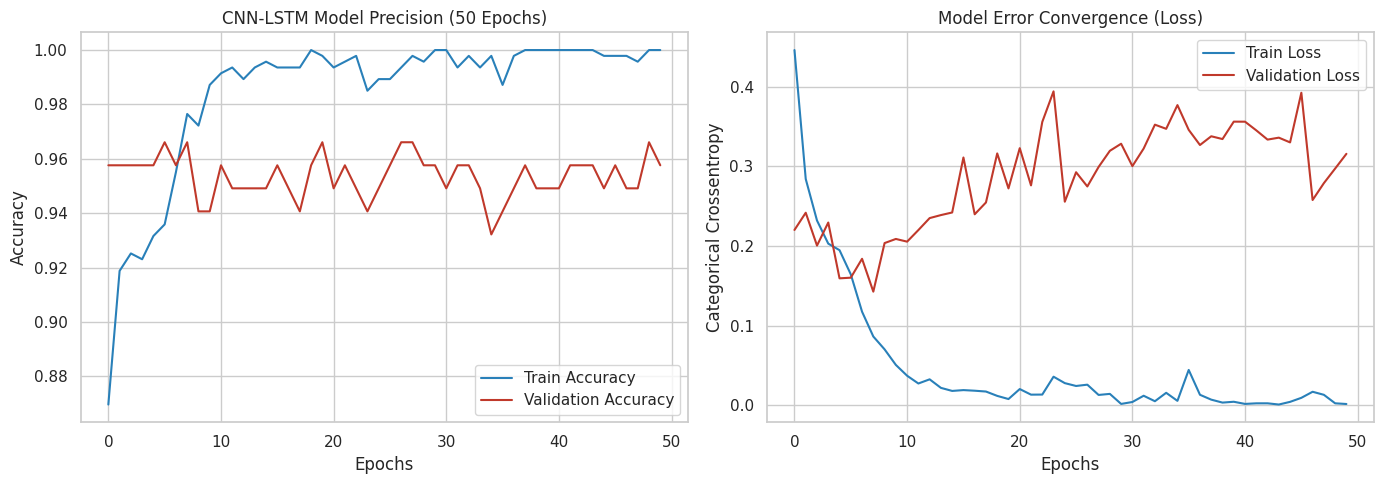

In [62]:
plt.figure(figsize=(14, 5))

# Accuracy Curve
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='#2980b9')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='#c0392b')
plt.title('CNN-LSTM Model Precision (50 Epochs)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='#2980b9')
plt.plot(history.history['val_loss'], label='Validation Loss', color='#c0392b')
plt.title('Model Error Convergence (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Categorical Crossentropy')
plt.legend()

plt.tight_layout()
plt.show()

Kernel Density Distribution

/tmp/ipython-input-4288301018.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['Temp'], shade=True, color="red", label="Temp Distribution")
/tmp/ipython-input-4288301018.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['SpO2'], shade=True, color="blue", label="SpO2 Distribution")


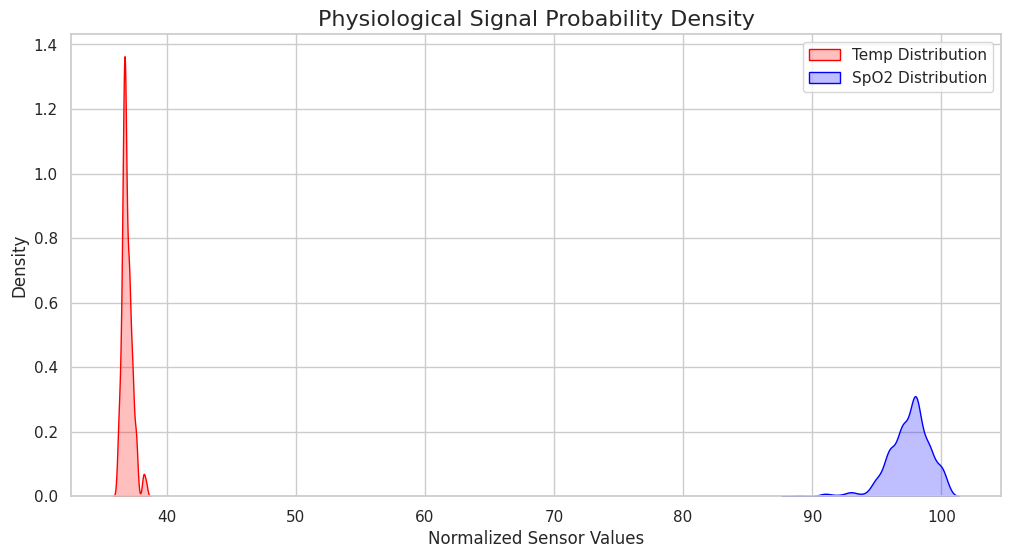

In [64]:
plt.figure(figsize=(12, 6))
sns.kdeplot(df['Temp'], shade=True, color="red", label="Temp Distribution")
sns.kdeplot(df['SpO2'], shade=True, color="blue", label="SpO2 Distribution")
plt.title('Physiological Signal Probability Density', fontsize=16)
plt.xlabel('Normalized Sensor Values')
plt.legend()
plt.show()

Export to Hardware (TFLite)

In [65]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

with open('hygeia_glove_final.tflite', 'wb') as f:
    f.write(tflite_model)

files.download('hygeia_glove_final.tflite')
print("✅ TFLite Model downloaded! Ready for ESP32 Deployment.")

Saved artifact at '/tmp/tmprnxn8vpb'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 10, 6), dtype=tf.float32, name='keras_tensor_16')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  137841571349328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137841571349904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137841574198352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137841574198928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137841571351056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137841571350480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137841571348752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137841571350864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137841571351824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137841571352400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137841571351632: 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ TFLite Model downloaded! Ready for ESP32 Deployment.
